# Coursera IBM Data Science Capstone Project
## "The Battle of Neighborhoods"
### Analyzing location for an Indian restaurant in Toronto, Canada

                                                          by Ruchir Palkar

 In this project, my job as Data Scientist is to locate best neighborhoods in Toronto city for starting new Indian restaurant. I am going to analyze neighborhoods and venue data of Toronto city for this project.So lets begins.

### 1. Importing libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    certifi-2019.6.16          |           py36_1         149 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    altair-3.1.0               |           py36_0         724 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.2 MB

The following NEW packages will be 

### 2.Scraping data from Wikipedia page into a DataFrame

In [6]:
import urllib.request
import pandas as pd
import numpy as np

#specify the url
wiki = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

#Query the website and return the html to the variable 'page'
page=urllib.request.urlopen(wiki)

#import the Beautiful soup functions to parse the data returned from the website
from bs4 import BeautifulSoup

#Parse the html in the 'page' variable, and store it in Beautiful Soup format
soup = BeautifulSoup(page)

#Selecting table with class='wikitable sortable'
table = soup.find('table',{'class':'wikitable sortable'})
table_rows = table.find_all('tr')

data = []
for row in table_rows:
    data.append([t.text.strip() for t in row.find_all('td')])

df = pd.DataFrame(data, columns=['Postalcode', 'Borough', 'Neighborhood'])
df.head()

#Dropping rows where BOUROUGH = Not assigned
df.drop(df[df['Borough']=='Not assigned'].index,inplace=True)

#Assigning value of Neighborhood same as Borough if Neighborhood == "Not assigned"
df['Neighborhood'] = np.where(df['Neighborhood'] =="Not assigned", df['Borough'], df['Neighborhood'])

#Creating new dataframe grouped by Postalcode & Borough
df_new =df.groupby(['Postalcode','Borough'],as_index=False).agg(lambda x: ','.join(x))
df_new.head(10)

#Loading geographical coordinates of each postal code from csv file
df_geo= pd.read_csv('https://cocl.us/Geospatial_data')

#Renaming column for merging purpose
df_geo.rename(columns = {'Postal Code': 'Postalcode'}, inplace=True)

#Merging two dataframes on POSTALCODE
df_merged=pd.merge(df_new, df_geo, on='Postalcode')
df_merged.head(2)

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497


In [7]:
df_merged.dtypes

Postalcode       object
Borough          object
Neighborhood     object
Latitude        float64
Longitude       float64
dtype: object

In [8]:
#Doing some essential steps like renaming columns & conversions
df_merged.rename(columns={'Postalcode': 'PostalCode'}, inplace=True)


In [9]:
#Now grouping by BOROUGH and getting count of Neighborhoods
df_merged.groupby('Borough').count()['Neighborhood']

Borough
Central Toronto      9
Downtown Toronto    18
East Toronto         5
East York            5
Etobicoke           12
Mississauga          1
North York          24
Queen's Park         1
Scarborough         17
West Toronto         6
York                 5
Name: Neighborhood, dtype: int64

In [11]:
#As we are interested in Toronto, getting Borough containing TORONTO word

df_toronto= df_merged[df_merged['Borough'].str.contains('Toronto')]
df_toronto.reset_index(inplace=True)
df_toronto.drop('index', axis=1, inplace=True)
df_toronto.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West,Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West,India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [12]:
#Checking the no of neighborhoods by grouping by BOROUGH
print(df_toronto.groupby('Borough').count()['Neighborhood'])

Borough
Central Toronto      9
Downtown Toronto    18
East Toronto         5
West Toronto         6
Name: Neighborhood, dtype: int64


In [13]:
#Now creating list of just Boroughs 
boroughs = df_toronto['Borough'].unique().tolist()

### 3. Get the geographical coordinates of Toronto city

In [15]:
#Getting lattitude & longitude of Toronto city
address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
lat_toronto = location.latitude
lon_toronto = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(lat_toronto, lon_toronto))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [16]:
#Colors for Borough
borough_color = {}
for borough in boroughs:
    borough_color[borough]= '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3)) 

### 4. Create a map of Toronto with neighborhoods

In [17]:
#Now creating map

import folium
from sklearn.cluster import KMeans


map_toronto = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], 
                                           df_toronto['Longitude'],
                                           df_toronto['Borough'], 
                                           df_toronto['Neighborhood']):
    label_text = borough + ' - ' + neighborhood
    label = folium.Popup(label_text)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=borough_color[borough],
        fill_color=borough_color[borough],
        fill_opacity=0.7).add_to(map_toronto)  
    
map_toronto

### 5. Use the Foursquare API to explore the neighborhoods

In [19]:
CLIENT_ID = '1JRHGMJW2D3NR4QJEVU5KJB2C00KB5DK1TTWZTYLIJFQ0TOY' 
CLIENT_SECRET = 'XPK5Q4DG21DKSSZLILCGU54OGH0AOZTVLFDKBEAKZ0CAM1TC' 
VERSION = '20180605' 
LIMIT=500
radius=500

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 1JRHGMJW2D3NR4QJEVU5KJB2C00KB5DK1TTWZTYLIJFQ0TOY
CLIENT_SECRET:XPK5Q4DG21DKSSZLILCGU54OGH0AOZTVLFDKBEAKZ0CAM1TC


In [20]:
#Function for getting near by VENUES
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
             v['venue']['id']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                    'Venue ID']
    
    return(nearby_venues)

In [22]:
#Now using above funtion for getting venues for all neighborhoods in  TORONTO dataset
toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                latitudes=df_toronto['Latitude'],
                                longitudes=df_toronto['Longitude'])

The Beaches
The Danforth West,Riverdale
The Beaches West,India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park,Summerhill East
Deer Park,Forest Hill SE,Rathnelly,South Hill,Summerhill West
Rosedale
Cabbagetown,St. James Town
Church and Wellesley
Harbourfront,Regent Park
Ryerson,Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide,King,Richmond
Harbourfront East,Toronto Islands,Union Station
Design Exchange,Toronto Dominion Centre
Commerce Court,Victoria Hotel
Roselawn
Forest Hill North,Forest Hill West
The Annex,North Midtown,Yorkville
Harbord,University of Toronto
Chinatown,Grange Park,Kensington Market
CN Tower,Bathurst Quay,Island airport,Harbourfront West,King and Spadina,Railway Lands,South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place,Underground city
Christie
Dovercourt Village,Dufferin
Little Portugal,Trinity
Brockton,Exhibition Place,Parkdale Village
High Park,The Junction South
Parkdale,Roncesvall

In [23]:
#Size of toronto_venues dataframe
toronto_venues.shape

(1696, 8)

In [24]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail,4bd461bc77b29c74a07d9282
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store,4ad4c062f964a52011f820e3
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub,4b8daea1f964a520480833e3
3,The Beaches,43.676357,-79.293031,Glen Stewart Ravine,43.676300,-79.294784,Other Great Outdoors,56afcad6498e05333bf42031
4,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood,4df91c4bae60f95f82229ad5


In [25]:
#Number of venues per neighborhood
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID
Neighborhood,,,,,,,
"Adelaide,King,Richmond",100,100,100,100,100,100,100
Berczy Park,57,57,57,57,57,57,57
"Brockton,Exhibition Place,Parkdale Village",23,23,23,23,23,23,23
Business Reply Mail Processing Centre 969 Eastern,17,17,17,17,17,17,17
"CN Tower,Bathurst Quay,Island airport,Harbourfront West,King and Spadina,Railway Lands,South Niagara",16,16,16,16,16,16,16
"Cabbagetown,St. James Town",45,45,45,45,45,45,45
Central Bay Street,83,83,83,83,83,83,83
"Chinatown,Grange Park,Kensington Market",100,100,100,100,100,100,100
Christie,16,16,16,16,16,16,16


In [26]:
#Now getting number of unique venue categories
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 236 uniques categories.


In [27]:
#Getting the list of categories
toronto_venues['Venue Category'].unique()[:100]

array(['Trail', 'Health Food Store', 'Pub', 'Other Great Outdoors',
       'Neighborhood', 'Greek Restaurant', 'Ice Cream Shop',
       'Cosmetics Shop', 'Italian Restaurant', 'Brewery', 'Yoga Studio',
       'Fruit & Vegetable Store', 'Dessert Shop', 'Pizza Place',
       'Bookstore', 'Restaurant', 'Juice Bar', 'Bubble Tea Shop',
       'Furniture / Home Store', 'Indian Restaurant', 'Spa',
       'Grocery Store', 'Diner', 'Coffee Shop', 'Caribbean Restaurant',
       'Bakery', 'Sports Bar', 'American Restaurant', 'Liquor Store',
       'Fish & Chips Shop', 'Burger Joint', 'Gym', 'Park',
       'Sushi Restaurant', 'Pet Store', 'Steakhouse', 'Burrito Place',
       'Movie Theater', 'Fast Food Restaurant', 'Sandwich Place',
       'Food & Drink Shop', 'Fish Market', 'Café', 'Cheese Shop',
       'Comfort Food Restaurant', 'Chinese Restaurant',
       'Middle Eastern Restaurant', 'Thai Restaurant',
       'Seafood Restaurant', 'Stationery Store', 'Coworking Space',
       'Gastropub', 'La

In [28]:
# As we are interested in Indian restaurants, now checking if the results contain "Indian Restaurant"

"Indian Restaurant" in toronto_venues['Venue Category'].unique()

True

### 6. Analyzing Each Neighborhood

In [29]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhoods'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

print(toronto_onehot.shape)
toronto_onehot.head()

(1696, 237)


,Neighborhoods,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Yoga Studio
0,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [30]:
#Nowing grouping rows by neighborhood and by taking the mean of the frequency of occurrence of each category
toronto_grouped = toronto_onehot.groupby(["Neighborhoods"]).mean().reset_index()

print(toronto_grouped.shape)
toronto_grouped.head()

(38, 237)


,Neighborhoods,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Yoga Studio
0,"Adelaide,King,Richmond",0.0,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.03,0.0,0.0,0.010000,0.01,0.0,0.03,0.0,0.000000,0.0,0.0,0.000000,0.020000,0.0,0.040000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0000,0.01,0.0000,0.01,0.030000,0.000000,0.0,0.01,0.03,0.010000,0.0,0.0,0.050000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.070000,0.0,0.0,0.0,0.01,0.000000,0.000000,0.020000,0.000000,0.030000,0.0,0.000000,0.0,0.0,0.0,0.01,0.01,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.01,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.01

In [31]:
#Now getting total no of INDIAN restaurant
total_ind_restaurants=len(toronto_grouped[toronto_grouped["Indian Restaurant"] > 0])
total_ind_restaurants

9

In [32]:
#Getting India Restaurants 
to_indian = toronto_grouped[["Neighborhoods","Indian Restaurant"]]
to_indian.sort_values(by=['Indian Restaurant'], inplace=True, ascending=False)
to_indian.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,Neighborhoods,Indian Restaurant
34,"The Annex,North Midtown,Yorkville",0.043478
11,Davisville,0.028571
6,Central Bay Street,0.024096
37,"The Danforth West,Riverdale",0.023810
5,"Cabbagetown,St. James Town",0.022222


### 7. Clustering Neighborhoods

Running k-means to cluster the neighborhoods in Toronto into 3 clusters.

In [33]:
# set number of clusters
clusters = 3

to_clustering = to_indian.drop(["Neighborhoods"], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=clusters, random_state=0).fit(to_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 1, 1, 2, 2, 2, 2, 0], dtype=int32)

In [39]:
#Creating a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
to_merged = to_indian.copy()

# add clustering labels
to_merged["Cluster Labels"] = kmeans.labels_

In [40]:
to_merged.rename(columns={"Neighborhoods": "Neighborhood"}, inplace=True)
to_merged.head()

,Neighborhood,Indian Restaurant,Cluster Labels
34,"The Annex,North Midtown,Yorkville",0.043478,1
11,Davisville,0.028571,1
6,Central Bay Street,0.024096,1
37,"The Danforth West,Riverdale",0.023810,1
5,"Cabbagetown,St. James Town",0.022222,1


### 8. Examining Clusters

In [41]:
# merging toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
to_merged = to_merged.join(toronto_venues.set_index("Neighborhood"), on="Neighborhood")

print(to_merged.shape)
to_merged.head()

(1696, 10)


,Neighborhood,Indian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID
34,"The Annex,North Midtown,Yorkville",0.043478,1,43.67271,-79.405678,Roti Cuisine of India,43.674618,-79.408249,Indian Restaurant,4c62c59ce1621b8dd0332453
34,"The Annex,North Midtown,Yorkville",0.043478,1,43.67271,-79.405678,Ezra's Pound,43.675153,-79.405858,Café,4ae7bc29f964a52084ad21e3
34,"The Annex,North Midtown,Yorkville",0.043478,1,43.67271,-79.405678,Rose & Sons,43.675668,-79.403617,American Restaurant,50abfac3e4b05922967ebe89
34,"The Annex,North Midtown,Yorkville",0.043478,1,43.67271,-79.405678,Live Organic Food Bar,43.675053,-79.406715,Vegetarian / Vegan Restaurant,4ad4c061f964a52099f720e3
34,"The Annex,North Midtown,Yorkville",0.043478,1,43.67271,-79.405678,Madame Boeuf And Flea,43.675240,-79.406620,Burger Joint,5929ae709deb7d7d29b7ad46


In [42]:
# sorting the results by Cluster Labels
print(to_merged.shape)
to_merged.sort_values(["Cluster Labels"], inplace=True)
to_merged.head()

(1696, 10)


,Neighborhood,Indian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID
32,Stn A PO Boxes 25 The Esplanade,0.0,0,43.646435,-79.374846,LCBO,43.642944,-79.372440,Liquor Store,4aeb719af964a52020c221e3
20,"Harbourfront,Regent Park",0.0,0,43.654260,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop,53b8466a498e83df908c3f21
20,"Harbourfront,Regent Park",0.0,0,43.654260,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery,54ea41ad498e9a11e9e13308
21,"High Park,The Junction South",0.0,0,43.661608,-79.464763,Shoxs,43.665353,-79.463563,Bar,4b26d1aff964a520698124e3
21,"High Park,The Junction South",0.0,0,43.661608,-79.464763,La Revolucion,43.665460,-79.464308,Mexican Restaurant,4d767b57d6688cfa8c1f1e15


### 9. Visualizing the clusters

In [53]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=11)

# set color scheme for the clusters
x = np.arange(clusters)
ys = [i+x+(i*x)**2 for i in range(clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(to_merged['Neighborhood Latitude'], to_merged['Neighborhood Longitude'], to_merged['Neighborhood'], to_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [44]:
# save the map as HTML file
map_clusters.save('map_clusters.html')

After observing map we can conclude that Cluster 0 (Red) does not have Indian Restaurant in its Neighborhoods.Hence opening Indian Restaurant will be best option. But among those Neighborhoods which one will be BEST one?. For this problem, we will sort Neighborhoods on basis of total number of restaurants & hotels in particular Neighborhood. NEIGHBORHOOD WITH HIGH NUMBER OF HOTELS & RESTAURANTS suggests that this neighborhood is famous for hotels & restaurants as compare to other neighborhoods in the cluster 0.

So lets find out which neighborhood wins.

### 10. Analysis on Cluster 0 for finding total number of hotels & restaurant in each neighborhood

#### This analysis will give neighborhoods which are famous for restaurants & hotels in Cluster 0.

In [45]:
#Adding details of Cluster 0 in new dataframe
df_cluster_zero=to_merged[to_merged["Cluster Labels"]==0]

In [46]:
#Now creating dataframe for hotels & restaurant in those neighborhood
df_venues2 = df_cluster_zero.copy()
df_venues3 = df_cluster_zero.copy()
df_venues_rest = df_venues2[df_venues2['Venue Category'].str.contains('Restaurant')].reset_index(drop=True)
df_venues_rest['Venue Type'] = 'Restaurant'
df_venues_hotel = df_venues3[df_venues3['Venue Category'].str.contains('Hotel')].reset_index(drop=True)
df_venues_hotel['Venue Type'] = 'Hotel'
df_venues_final = pd.concat([df_venues_rest,df_venues_hotel]).reset_index(drop=True)
df_venues_final.shape

(280, 11)

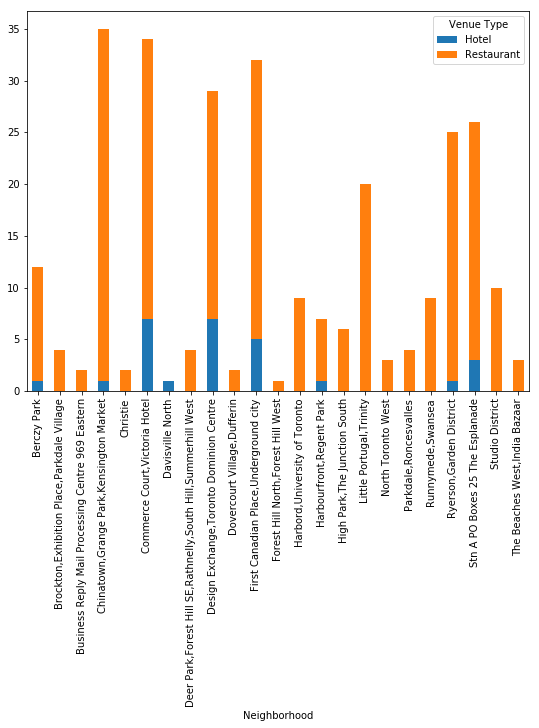

In [48]:
#Plotting 
df_venues_final.groupby('Neighborhood')['Venue Type']\
    .value_counts()\
    .unstack(level=1)\
    .plot.bar(stacked=True,figsize=(9,7))

## Now creating table for same results as in plot

In [49]:
#Creating table
#Now grouping by Neighborhood & getting Total Hotels & Restaurants in each Neighborhood of Cluster 0
df_total_HnR =pd.DataFrame()
df_total_HnR=df_venues_final.groupby('Neighborhood')['Venue Type'].value_counts().unstack(level=1)
df_total_HnR['Total H & R']=df_total_HnR.fillna(0)['Hotel']+df_total_HnR.fillna(0)['Restaurant']
df_total_HnR.sort_values(by=['Total H & R'], inplace=True, ascending=False)

#As count was in float we are now converting into int
df_total_HnR["Hotel"] = df_total_HnR["Hotel"].fillna("0").astype(int)
df_total_HnR["Restaurant"] = df_total_HnR["Restaurant"].fillna("0").astype(int)
df_total_HnR["Total H & R"] = df_total_HnR["Total H & R"].fillna("0").astype(int)
df_total_HnR.head()

Venue Type,Hotel,Restaurant,Total H & R
Neighborhood,,,
"Chinatown,Grange Park,Kensington Market",1,34,35
"Commerce Court,Victoria Hotel",7,27,34
"First Canadian Place,Underground city",5,27,32
"Design Exchange,Toronto Dominion Centre",7,22,29
Stn A PO Boxes 25 The Esplanade,3,23,26


Now we got neighborhoods with total number of hotels & restaurant in it. Going one step ahead and analyzing venues data for top 5 neighborhoods. More venues in that neighborhood means MORE FOOT TRAFFIC (More customers)

### 11. Analysis on Cluster 0 for finding total number of venues in each neighborhood

In [50]:
# Now getting total VENUES count in each Neighborhood of Cluster 0
venue_counts=df_venues2.groupby('Neighborhood')['Venue'].value_counts().unstack(level=1)
#Adding new column 'Total Venues'.Last column do check
venue_counts['Total Venues'] = venue_counts.fillna(0)[list(venue_counts.columns)].sum(axis=1)
venue_counts.sort_values(by=['Total Venues'], inplace=True, ascending=False)
venue_counts.head()

Venue,306 Yonge Street - Jordan Store,4 Life Natural Foods,7-Eleven,900 Mount Pleasant - Residents Gym,A & C Games,A & C World,A Dark Horse,A Good Read,A&W Canada,ARTiculations,Academy Of Lions CrossFit Toronto,Actinolite,Adelaide Club Toronto,Air Canada Check-In Counter,Air Canada Club,Ajisen Ramen 味千拉麵,Akai Sushi,Alex Murray Parkette,Alexandra Park,Alexandro's World Famous Gyros,Ali Baba's - Yonge north of Dundas,Ali Basha Cafè,Alliance Cinemas - The Beach,Almond Butterfly,Amano Pasta,Amber European Restaurant,Amin Car Repair Garage,Anh Dao,Anton Kozlik's mustard,Anytime Fitness,Archeo,Aris Grill,Arrivals + Departures,Arta Gallery,Artscape Youngplace,Arvo,Asa Sushi,Ashbridges Bay Skatepark,Asian Legend 味香村,Assembly Chef's Hall,Athletic Centre,Aveda Institute Toronto,Awai,B.GOOD,BMV Books,BYOB Cocktail Emporium,Bakka Phoenix Books,Baldini,Balzac's Coffee,Balzac’s Coffee Roasters,Bang Bang Ice Cream & Bakery,Banh Mi Boys,Banh Mi Nguyen Huong,Bar Fancy,Barberian's Steak House,Bardi's Steak House,Barreworks,Barrio Cerveceria,Bath & Body Works,Bazara,Beauty Boutique by Shoppers Drug Mart,Beerbistro,Bellevue Square Park,Bellwoods Brewery,Berczy Park,Berkeley Church,Best Western Roehampton Hotel & Suites,Bier Markt Esplanade,Biff's Bistro,Big Fat Burrito,Big Trouble,Billy Bishop Café,Billy Bishop Toronto City Airport (YTZ) (Billy Bishop Toronto City Airport),Blackbird Baking Co,Blaze Pizza,Blo Blow Dry Bar,Blood Brothers Brewing,Bloom Restaurant,Bloor-Jane Restaurant,Blue Banana Market,Bobbie Sue's Mac + Cheese,Body Blitz Spa East,Bonjour Brioche,Book City (Bloor West),Booster Juice,Bosk at Shangri-La,Bourbon St. Grill,Boxcar Social,Boxcar Social Temperance,Brett's Ice Cream,Brick Street Bakery,Brick Street Breads,British Style Fish & Chips,Brookfield Place,Brooklyn Tavern,Bryden's Pub,Bubble Republic Tea House 奶茶黨部,Buddha's Vegetarian,Budget Car & Truck Rental,Bulldog On The Block,Bunner's Bake Shop,Burrito Bandidos,Burrito Boyz,Buster's Sea Cove,Butler's Pantry,Byblos Toronto,Bymark,Böehmer,C'est Bon,C'est What,CC Lounge,CF Toronto Eaton Centre,Cacao 70,Cactus Club Cafe,Cafe Cancan,Cafe Landwer,Cafe Neon,Caffe Furbo,Caffino,Café Pamenar,Café Plenty,Cambridge Suites Toronto,Campo,Canadian Opera Company,Canoe,Carisma,Carlos' House of Spice,Carmen,Carousel Bakery,Casa di Giorgio,Ceiling Champions,Charlie's Gallery,Chatime 日出茶太,Chica’s Nashville Hot Chicken,Chick-n-Joy,Chino Locos,Chipotle Mexican Grill,Cider House,Cineplex Cinemas Yonge-Dundas,Citrus Restaurant & Lounge @ The Grand Hotel,Civello Salon,Classico,Club Monaco,Cluny Bistro & Boulangerie,Coach House Printing,Cocina Economica,Coffee Tree,Coffee Tree Roastery,Cold Tea,College Backpackers,Comfort Zone,Contra Cafe,Cool Hand of a Girl,Copacabana Grilled Brazilian,Corktown Common,Cosmic Treats,Cosmopolitan Toronto Centre Hotel & Spa,Country Style,Courage My Love,Craft Beer Market,Crepe Delicious,Crepe It Up!,Crepe TO,Crew Room,D.W. Alexander,DAVIDsTEA,DT Bistro,Daeco Sushi,Dakota Tavern,Dark Horse Espresso Bar,Delica Kitchen,Design Exchange,Dineen @CommerceCourt,Dineen Coffee,Dipped,Disney store,Distillery Sunday Market,District 28,Dog Fountain,Dolce Gelato Kensington,Dollarama,Domani Restaurant & Wine Bar,Dominion Pub and Kitchen,Drake General Store,Drake One Fifty,Dufflet Pastries,Duke's Refresher + Bar,Dumpling House,Dunn Milk Variety,Dupont Disco,Dwell Gym,EAT BKK Thai Kitchen,EB Games,Earls Kitchen & Bar,East End Garden Centre & Hardware,East of Brunswick,Eaton Centre Fountain,Ed Mirvish Theatre,Ed's Real Scoop,Edward Hanlan Statue,Eggspectation,El Almacen Yerba Mate Cafe + Gallery,El Catrin,El Rey,El Trompo,Elgin And Winter Garden Theatres,Elmwood Spa,Equinox Bay Street,Essence of Life Organics,Estiatorio Volos,Ethiopiques,European Delight,Everyday Gourmet (Teas & Coffees),FARMR Eatery & Catering,FIKA Cafe,FILM CAFE,FLOCK Rotisserie + Greens,Faema Caffe,Falafel World,Fat Bastard Burrito,Fiesta Farms,Figs Breakfast & Lunch,Fine Asian Bowl,Fionn MacCool's,First Canadian Pla

In [51]:
#Now getting total VENUES
df_total_venues=pd.DataFrame()
df_total_venues=venue_counts.loc[:,'Total Venues']
df_total_venues=venue_counts['Total Venues'].astype(int)
df_total_venues.head()

Neighborhood
Design Exchange,Toronto Dominion Centre    100
Ryerson,Garden District                    100
Chinatown,Grange Park,Kensington Market    100
Commerce Court,Victoria Hotel              100
First Canadian Place,Underground city      100
Name: Total Venues, dtype: int64

#### Since Foursquare allows max. 100 venues in Free plan. I am getting max. 100 venues.In other plans it would work better

### 12. Merging total VENUES & total hotels n Restaurant in each neighborhood

In [52]:
#Now merging total VENUES & total hotels n Restaurant in each neighborhood
df_final=pd.merge(df_total_HnR, df_total_venues, on='Neighborhood')
df_final.head()

,Hotel,Restaurant,Total H & R,Total Venues
Neighborhood,,,,
"Chinatown,Grange Park,Kensington Market",1,34,35,100
"Commerce Court,Victoria Hotel",7,27,34,100
"First Canadian Place,Underground city",5,27,32,100
"Design Exchange,Toronto Dominion Centre",7,22,29,100
Stn A PO Boxes 25 The Esplanade,3,23,26,96


## Conclusion-
My client can start an INDIAN restaurant in following neighborhoods for better profit.
1. Chinatown,Grange Park,Kensington Market 
2. Commerce Court,Victoria Hotel 
3. First Canadian Place,Underground city.
4. Design Exchange,Toronto Dominion Centre
5. Stn A PO Boxes 25 The Esplanade

These neighborhoods has lots of hotels,restaurants & venues but no INDIAN restuarant.